In [74]:
import pandas as pd
import numpy as np
import os
import datetime
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [75]:
sales_data = pd.read_csv('dry/SalesData-Table 1.csv')

In [163]:
all_dates = sales_data['日期'].to_numpy()[:911]

In [77]:
def to_date_obj(date_str):
    m, d, y = date_str.split('/')
    ret = datetime.datetime(int('20'+y), int(m), int(d))
    return ret
sales_data['日期'] = sales_data['日期'].apply(to_date_obj)

In [116]:
def split_df(sales_data):
    all_sales = {}
    all_sell = {}
    all_orders = {}
    all_storage = {}

    for x in pd.unique(sales_data['貨號']):
        all_sales[x] = sales_data[sales_data['貨號']==x]
        all_sell[x] = all_sales[x]['銷售數量']
        all_orders[x] = all_sales[x]['進貨數量']
        all_storage[x] = all_sales[x]['庫存數量']
        temp_array = [all_sell[x], all_orders[x], all_storage[x]]
        with open('dry/'+str(x)+'.pkl', 'wb') as file:
            pickle.dump(temp_array, file)
        all_storage[x].fillna(-200, inplace=True)
        all_orders[x].fillna(-200, inplace=True)
        all_sell[x].fillna(-200, inplace=True)
    return all_sales, all_sell, all_orders, all_storage

In [117]:
all_sales, all_sell, all_orders, all_storage = split_df(sales_data)

In [152]:
# Can plot maximum 11 merchs
def plot_nvec(idxs, data, purchases, storages):
    for idx in idxs:
        print("Merch:",idx)
    c = {}
    for i in range(len(idxs)):
        c[idxs[i]] = i
    colors = cm.rainbow(np.linspace(0, 1, len(c)))
    fontsize = 15
    x = range(911)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(15,25))
    
    for idx in idxs:
        ax1.scatter(x, data[idx], s=10, color=colors[c[idx]], marker="s", label=idx)
    ax1.legend()
    ax1.set_xlabel('day', fontsize = fontsize)
    ax1.set_ylabel('amount', fontsize = fontsize)
    ax1.set_title('Sell', fontsize = fontsize)

    
    for idx in idxs:
        ax2.scatter(x, purchases[idx], s=10, color=colors[c[idx]], marker="s", label=idx)
    ax2.legend()
    ax2.set_xlabel('day', fontsize = fontsize)
    ax2.set_ylabel('amount', fontsize = fontsize)
    ax2.set_title('Orders', fontsize = fontsize)
    
    for idx in idxs:
        ax3.scatter(x, purchases[idx]-data[idx], s=10, color=colors[c[idx]], marker="s", label=idx)
    ax3.legend()
    ax3.set_xlabel('day', fontsize = fontsize)
    ax3.set_ylabel('amount', fontsize = fontsize)
    ax3.set_title('Orders - Sell', fontsize = fontsize)
    
    for idx in idxs:
        ax4.scatter(x, storages[idx], s=10, color=colors[c[idx]], marker="s", label=idx)
    ax4.legend()
    ax4.set_xlabel('day', fontsize = fontsize)
    ax4.set_ylabel('amount', fontsize = fontsize)
    ax4.set_title('Storages', fontsize = fontsize)
     
    for idx in idxs:
        ax5.scatter(range(910), storages[idx][1:].to_numpy()-storages[idx][:-1].to_numpy()\
                    -purchases[idx][1:].to_numpy()+data[idx][1:].to_numpy()
                    , s=10, color=colors[c[idx]], marker="s", label=idx)
    ax5.legend()
    ax5.set_xlabel('day', fontsize = fontsize)
    ax5.set_ylabel('amount', fontsize = fontsize)
    ax5.set_title('delta_Storage - orders + sells', fontsize = fontsize)
    

    fig.tight_layout()
    plt.show()

Merch: 90060103


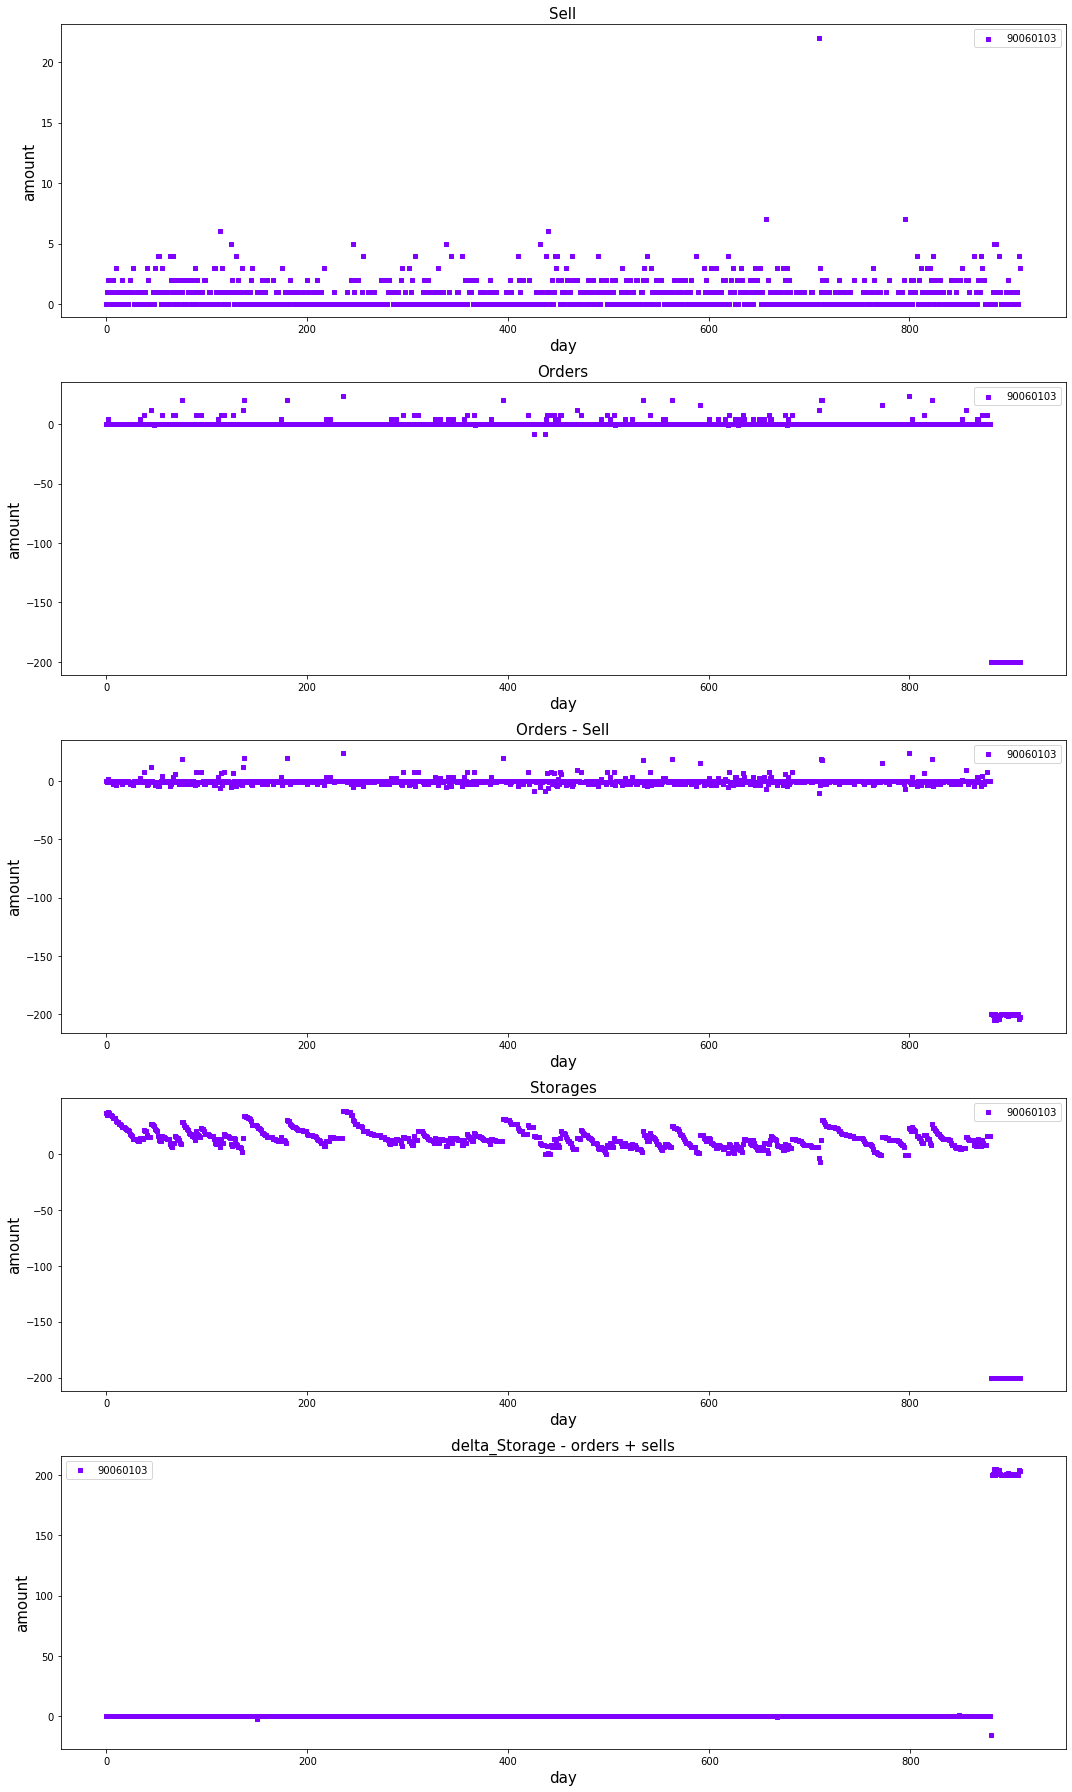

In [219]:
all_indices = pd.unique(sales_data['貨號'])
plot_nvec(all_indices[2:3], all_sell, all_orders, all_storage )

In [112]:
# Get the amount and the proportion of dates when orders <= sells 
#(excluding dates when orders are 0 or there is no information of the orders)
# This means that there is still room for improvement of the ordering strategy
def get_stats(sell, orders):
    start_time= time.time()
    total = 0
    valid_counts = 0
    target_less = 0
    target_equal = 0
    for x in sell:
        temp_sell = sell[x].to_numpy()
        temp_orders = orders[x].to_numpy()
        for y in range(temp_sell.shape[0]):
            total += 1
            if temp_orders[y] - temp_sell[y]<0 and (temp_orders[y]!=0) and (temp_orders[y]!=-200):
                target_less += 1
            if temp_orders[y] - temp_sell[y]==0 and (temp_orders[y]!=0)and (temp_orders[y]!=-200):
                target_equal += 1
            if (temp_orders[y] != 0) and (temp_orders[y]!=-200):
                valid_counts += 1
    print("Total counts:", total)
    print("Total sales < purchases:",target_less, ", accounting for:", target_less/total, "of total counts.")
    print("Total sales == purchases:",target_equal, ", accounting for:", target_equal/total, "of total counts.")
    print("Total sales <= purchases:",target_equal+target_equal, ", accounting for:", (target_equal+target_less)/total, "of total counts.")
    print("\n\nTotal valid counts:",valid_counts)
    print("Total sales < purchases:",target_less, ", accounting for:", target_less/valid_counts, "of valid counts.")
    print("Total sales == purchases:",target_equal, ", accounting for:", target_equal/valid_counts, "of valid counts.")
    print("Total sales <= purchases:",target_equal+target_equal, ", accounting for:", (target_equal+target_less)/valid_counts, "of valid counts.")
    print("\nElapsed time:", time.time()- start_time, "secs")

In [111]:
get_stats(all_sell, all_orders)

Total counts: 7288
Total sales < purchases: 86 , accounting for: 0.011800219538968168 of total counts.
Total sales == purchases: 8 , accounting for: 0.0010976948408342481 of total counts.
Total sales <= purchases: 16 , accounting for: 0.012897914379802415 of total counts.


Total valid counts: 883
Total sales < purchases: 86 , accounting for: 0.09739524348810873 of valid counts.
Total sales == purchases: 8 , accounting for: 0.009060022650056626 of valid counts.
Total sales <= purchases: 16 , accounting for: 0.10645526613816535 of valid counts.

Elapsed time: 0.02174997329711914 secs


In [217]:
for idx in all_indices:
    print("\n\nMerch:",idx)
    sub = all_storage[idx][1:].to_numpy()-all_storage[idx][:-1].to_numpy()\
         -all_orders[idx][1:].to_numpy()+all_sell[idx][1:].to_numpy()
#     print(all_storage[idx][148:152], all_storage[idx][149:153], all_orders[idx][148:152], all_sell[idx][148:152])
    fault_pts = np.where(sub)
    sub = sub[fault_pts]
    fault_storages_after = all_storage[idx].to_numpy()[fault_pts[0]+1]
    fault_storages = all_storage[idx].to_numpy()[fault_pts]
    fault_sells = all_sell[idx].to_numpy()[fault_pts[0]+1]
    fault_orders = all_orders[idx].to_numpy()[fault_pts]
    filtered_pts = np.where(np.logical_and(fault_storages!=-200, fault_sells!=-200, fault_orders!=-200))[0]

    fault_pts = fault_pts[0][filtered_pts]
    fault_storages = fault_storages[filtered_pts]
    fault_sells = fault_sells[filtered_pts]
    fault_orders = fault_orders[filtered_pts]
    fault_storages_after = fault_storages_after[filtered_pts]
    print("sub:",sub[filtered_pts])
    print("Fault points:",fault_pts)
    print("Fault storages:",fault_storages)
    print("Fault storages after day:", fault_storages_after)
    print("Fault sells:",fault_sells)
    print("Fault orders:",fault_orders)
    print("Fault dates:",all_dates[fault_pts])



Merch: 6160195
sub: [  -1.   -5.   -2. -312.]
Fault points: [150 303 514 880]
Fault storages: [108. 227. 207. 325.]
Fault storages after day: [  93.  209.  177. -200.]
Fault sells: [14 13 28 13]
Fault orders: [0. 0. 0. 0.]
Fault dates: ['2017-05-31T00:00:00.000000000' '2017-10-31T00:00:00.000000000'
 '2018-05-30T00:00:00.000000000' '2019-05-31T00:00:00.000000000']


Merch: 6120009
sub: [  1.  -2. -23.]
Fault points: [667 848 880]
Fault storages: [10. 13. 24.]
Fault storages after day: [  11.   11. -200.]
Fault sells: [0 0 1]
Fault orders: [0. 0. 0.]
Fault dates: ['2018-10-30T00:00:00.000000000' '2019-04-29T00:00:00.000000000'
 '2019-05-31T00:00:00.000000000']


Merch: 90060103
sub: [ -2.  -1.   1. -16.]
Fault points: [150 667 848 880]
Fault storages: [25. 12.  5. 16.]
Fault storages after day: [  23.    8.    6. -200.]
Fault sells: [0 3 0 0]
Fault orders: [0. 0. 0. 0.]
Fault dates: ['2017-05-31T00:00:00.000000000' '2018-10-30T00:00:00.000000000'
 '2019-04-29T00:00:00.000000000' '2019